# Nonlinear Model Predictive Control (MPC) for quadcopter

The general form of a nonlinear Model Predictive Control (MPC) problem in continuous-time over a horizon $[t_0, t_f]$ is given by:

\begin{align}
\text{min}_{u} \quad & \mathcal{M}(x(t_f)) + \int_{t_0}^{t_f} \mathcal{L}(x(t),u(t)) \\[5pt]
\text{subject to} \quad & \dot{x}(t) = f(x(t),u(t)) \\[5pt]
\quad & g(x(t),u(t)) = 0 \\[5pt]
\quad & h(x(t),u(t)) \leq 0 \\[5pt]
& x(t_0)  = x_\text{initial},
\end{align}

where $x(t) \in \mathbb{R}^{n_x}$ is the state vector, $u(t) \in \mathbb{R}^{n_u}$ is the control input, $\mathcal{L}$ is the stage cost, $\mathcal{M}$ is the terminal cost, $f$ is the continuous-time dynamics, $g$ are the equality constraints, and $h$ are the inequality constraints. The initial condition is given by $x_\text{initial}$.

For tracking a reference trajector $(x_{ref}(t), u_{ref}(t))$, often a quadratic form of the stage and terminal costs is utilized:

$$ \mathcal{L}(x(t),u(t)) = (x(t) - x_{ref}(t))^T Q (x(t) - x_{ref}(t)) + u(t)-u_{ref}(t))^T R (u(t)-u_{ref}(t)) $$

and 

$$ \mathcal{M}(x(t_f)) = (x(t_f) - x_{ref}(t_f))^T Q_f (x(t_f) - x_{ref}(t_f)) $$
where, $Q_f$, $Q$, and $R$ are positive definite matrices. $Q_f$ represents the penalty for the terminal state discrepancy at $t=t_f$, while $Q$ and $R$ represent the continuous-time penalties for the state and control vector discrepancies, respectively.

The above problem is in continuous time. In order to solve it, we first discretize the optimization problem (typically in $N$ discrete steps in $[t_0, t_f]$). The discrete-time nonlinear MPC problem is then given by:

\begin{align}
\text{min}_{u} \quad & \mathcal{M}(x_N) + \sum_{k=0}^{N-1} \mathcal{L}(x_k,u_k) \\[5pt]
\text{subject to} \quad & x_{k+1} = f_{RK4}(x_k,u_k,\Delta t)\\[5pt]
\quad & g(x_k,u_k) = 0 \\[5pt]
\quad & h(x_k,u_k) \leq 0 \\[5pt]
& x_0  = x_\text{initial},
\end{align}
where $x_k$ and $u_k$ are the state and control input at time step $k$, and $\Delta t = \dfrac{t_f - t_0}{N}$ is the time step. In the above, the discretized dynamics is represented as $f_{RK4}$ with Runge-Kutta fourth order (RK4) integration, but any other discretization may also be be used.

If quadratic stage and terminal costs are chosen, their forms for tracking a reference trajectory are:

$$ \mathcal{L}(x_k,u_k) = (x_k - x_{ref,k})^T Q (x_k - x_{ref,k}) + (u_k-u_{ref,k})^T R (u_k-u_{ref,k}) $$

and 

$$ \mathcal{M}(x_N) = (x_N - x_{ref,N})^T Q_f (x_N - x_{ref,N}) $$
where, $x_{ref,k}$ and $u_{ref,k}$ are the reference state and control input at time step $k$. The constraints $h$ can, among other constraints, represent the bounds on the state and control vectors. Equality constraints $g$ may not always be present. 

The core idea of MPC is to solve the optimization problem in a horizon $[t_0, t_f]$, obtain the optimal control input $[u_{t_0}, u_{t0 + \Delta t}, u_{t_0 + 2\Delta t}, ...., u_{t_0 + (N-1)\Delta t}]$, but only apply the $u_{t_0}$ at the $t=t_0$ to the plant and advance its state to $t=t_0 + \Delta t$. Now, at $t=t_0 + \Delta t$, the advanced (receded) horizon is $t=[t_0 + \Delta t, t_f+\Delta t]$, in which a new nonlinear optimization problem is solved to obtain the optimal control input to be applied at $t=t_0 + \Delta t$. This process is iteratively repeated.

## Transcription and collocation

Depending on which variables are incorporated as optimization variables (decision variables) in the solution of the nonlinear optimization problem above, different methods emerge. 

1. **Direct transcription**: In this method, the state and control vectors at each time step are incorporated as decision variables. The state and control vectors are then optimized over the entire horizon. This method is computationally expensive as the number of decision variables increases with the number of time steps.

2. **Direct shooting**: In this method, only the control input at each time step is incorporated as a decision variable. The state vector is then obtained by integrating the dynamics from the initial state, thus eliminating the equality constraints for dynamics to be explicitly incorporated in the optimization problem. This method is computationally less expensive than direct transcription.

The method of dynamics integration and incorporation of constraints also leads to a variety of methods. Collocation methods are popular and widely used. They represent the state and control vectors in the trajectory as polynomials and often take advantage of the collocation points to enforce the dynamics constraints. A discussion of these methods is beyond the scope of this document, but the reader is referred to [1], and references therein, for a comprehensive discussion. 

Along with direct transcription and direct shooting implementations, currently Collimator provides the 'Hermite Simpson' collocation based MPC, which is also known as **direct collocation** [1].

We demonstrate these methods below for the quadcopter model.

In [1]:
import os
import time

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import collimator
from collimator import logging

from collimator.library import (
    SourceBlock,
    DirectTranscriptionNMPC,
    DirectShootingNMPC,
    HermiteSimpsonNMPC,
)

from collimator.models.quadcopter import (
    differentially_flat_state_and_control,
    make_quadcopter,
    animate_quadcopter,
    plot_sol,
)

logging.set_log_level(logging.ERROR)

CI = os.environ.get("CI", "false").lower() == "true"
CI = True # FIXME

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Quadcopter configuration

We set the inertia compoments $(I_{xx}, I_{yy}, I_{zz})$, rotor force and torque generation parameters $(k, b)$,  length $l$, mass $m$, and gravity $g$ to generate a quadcopter configuration.

In [2]:
nvars = 6  # x, y, z, phi, theta, psi
nstate = 12  # the 6 vars above and their derivatives
ncontrol = (
    4  # u_i = (\omega_i)**2, where \omega_i is the angular velocity of the rotor_i
)

# Quadcopter configuration
config = {
    "Ixx": 1.0,
    "Iyy": 1.0,
    "Izz": 2.0,
    "k": 1.0,
    "b": 0.5,
    "l": 1.0 / 3,
    "m": 2.0,
    "g": 9.81,
}

### Reference trajectory generation

We use the previous differentially flat analysis to generate a reference leminscate trajectory.

In [3]:
def get_sigma_leminscate(t):
    """The Leminscate trajectory (shape of eight) in the x-y plane"""
    tfac = 1.2
    x = 2.0 * jnp.cos(jnp.sqrt(2) * t / tfac)
    y = 2.0 * jnp.sin(jnp.sqrt(2) * t / tfac) * jnp.cos(jnp.sqrt(2) * t / tfac)
    z = 0.0
    # z = jnp.sin(jnp.sqrt(2)*t/tfac)

    phi = 0.0
    return jnp.array([x, y, z, phi])


# pick one of leminscate or circle trajectory
get_sigma = get_sigma_leminscate

# Functions to compute up to 4th order derivatives by automatic differentiation
get_sigma_d1 = jax.jacobian(get_sigma)
get_sigma_d2 = jax.jacobian(get_sigma_d1)
get_sigma_d3 = jax.jacobian(get_sigma_d2)
get_sigma_d4 = jax.jacobian(get_sigma_d3)


# function to get sigma and up to 4th order derivatives
def get_flat_inputs(t, config):
    flat_inputs = differentially_flat_state_and_control(
        get_sigma(t),
        get_sigma_d1(t),
        get_sigma_d2(t),
        get_sigma_d3(t),
        get_sigma_d4(t),
        **config,
    )
    return flat_inputs


# function to get the trajectory
generate_trajectory = jax.vmap(get_flat_inputs, (0, None))

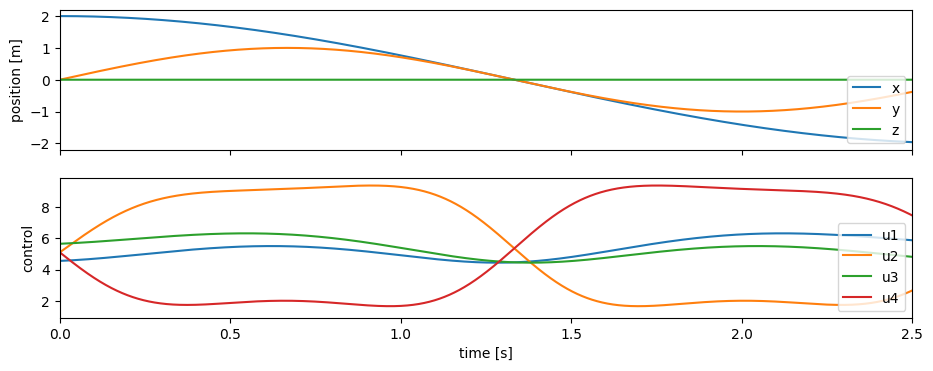

In [4]:
# Generate the reference trajectory

T_sim = 2.5
N_ref = 10000  # Time steps for reference trajectory

# Time for the reference trajectory.  Since the moving horizon can
# "look ahead" beyond the end of the simulation, we'll arbitrarily
# extend the reference trajectory by a factor of 2.
t_ref = jnp.linspace(0.0, 2 * T_sim, N_ref)

ref_traj = generate_trajectory(t_ref, config)

nx = nstate  # state dimension
nu = ncontrol  # control dimension

x_ref = ref_traj[:, :nx]
u_ref = ref_traj[:, nx:]

fig, axs = plt.subplots(2, 1, figsize=(11, 4), sharex=True)
axs[0].plot(t_ref, x_ref[:, 0:3])
axs[0].set_ylabel("position [m]")
axs[0].legend(["x", "y", "z"], loc="lower right")
axs[1].plot(t_ref, u_ref)
axs[1].set_ylabel("control")
axs[1].legend(["u1", "u2", "u3", "u4"], loc="lower right")
axs[1].set_xlabel("time [s]")
axs[1].set_xlim([0, T_sim])
plt.show()

# Direct transcription

In this case for a horizon of N steps, the decision variables are

$$ [x_0, x_1, \cdots, x_N,\quad u_0, u_1, \cdots, u_{N-1}].$$

Since $x_i$ form part of the decision variables, the dynamics appear as constraints. Thus the reference trajectories for $x$ is of size $([N+1] \times n_x)$ and the reference trajectory for $u$ is $(N \times n_u)$. These are also the sizes of the initial guesses for the optimization problem.

Let's look at the signature of `DirectTranscriptionNMPC` to understand the variables we need to create for this block.

In [5]:
print(DirectTranscriptionNMPC.__doc__)


    Implementation of nonlinear MPC with direct transcription and IPOPT as the NLP
    solver.

    Input ports:
        (0) x_0 : current state vector.
        (1) x_ref : reference state trajectory for the nonlinear MPC.
        (2) u_ref : reference input trajectory for the nonlinear MPC.

    Output ports:
        (1) u_opt : the optimal control input to be applied at the current time step
                    as determined by the nonlinear MPC.

    Parameters:
        plant: LeafSystem or Diagram
            The plant to be controlled.

        Q: Array
            State weighting matrix in the cost function.

        QN: Array
            Terminal state weighting matrix in the cost function.

        R: Array
            Control input weighting matrix in the cost function.

        N: int
            The prediction horizon, an integer specifying the number of steps to
            predict. Note: prediction and control horizons are identical for now.

        nh: int
            N

## MPC config

We can now create the variables for the MPC.

In [6]:
x0 = x_ref[
    0
]  # initial state vector for the plant, we can start with the first element of the reference trajectory

N = 10  # Number of time steps per MPC interval
nh = 2  # number of steps to take within an RK4 step for integration of dynamics
dt = 0.1  # timestep in the horizon

Q = 1.0 * jnp.eye(nx)  # Stage penalty matrix for state vector
QN = 3 * Q  # Terminal penalty matrix for state vector
R = 0.01 * jnp.eye(nu)  # Stage penalty matrix for control vector

lb_x = None  # no bound on state vector
ub_x = None  # no bound on state vector

lb_u = 0.0 * jnp.ones(nu)  # lower bound on control vector
ub_u = 20.0 * jnp.ones(nu)  # upper bound on control vector

x_optvars_0 = jnp.tile(x0, (N + 1, 1))  # initial guess for control vector: repear x0
u_optvars_0 = jnp.tile(
    u_ref[0], (N, 1)
)  # initial guess for control vector: repeat first element of reference trajectory

if CI:
    N = 2
    nh = 1
    x_optvars_0 = jnp.tile(x0, (N + 1, 1))
    u_optvars_0 = jnp.tile(u_ref[0], (N, 1))

## Interpolation block for reference trajectory

We can create a generic block to create the reference trajectories going N steps forward as follows:

In [7]:
class ReferenceTrajectory(SourceBlock):
    """
    Interpolate all columns of an array individually,
    and output the interpolated columns for times evaluated
    at N steps (including 0th step) of length dt starting
    at t=0.
    Params:
        t_vec: 1D array
        x_arr: nD array
        dt: timestep
        N: Number of steps to take

    Input ports:
        (0): scalar time `t`

    Output ports:
        (0): ndarray
            Interpolated x_arr values at t=0, t=dt, t=2*dt, ..., t=N*dt
    """

    def __init__(self, t_vec, x_arr, dt, N, *args, **kwargs):
        self.t_vec = t_vec
        self.x_arr = x_arr
        self.dt = dt
        self.N = N
        self.interp_fun = jax.vmap(jnp.interp, (None, None, 1))
        super().__init__(self.reference_trajectory_for_N_steps, *args, **kwargs)

    def _scan_t(self, _carry, t):
        return _carry, self.interp_fun(t, self.t_vec, self.x_arr)

    def reference_trajectory_for_N_steps(self, t):
        t_steps = t + self.dt * jnp.arange(self.N + 1)
        _, x_i = jax.lax.scan(self._scan_t, None, t_steps)
        return x_i

## Simulate MPC

Next, we build the Collimator diagram as usual.

In [8]:
builder = collimator.DiagramBuilder()

quadcopter = builder.add(
    make_quadcopter(config=config, initial_state=x0, name="quadcopter")
)

xref = builder.add(ReferenceTrajectory(t_ref, x_ref, dt, N, name="xref"))
uref = builder.add(ReferenceTrajectory(t_ref, u_ref, dt, N - 1, name="uref"))

mpc = builder.add(
    DirectTranscriptionNMPC(
        make_quadcopter(config=config, initial_state=x0, name="quadcopter"),
        Q,
        QN,
        R,
        N,
        nh,
        dt,
        lb_x=lb_x,
        ub_x=ub_x,
        lb_u=lb_u,
        ub_u=ub_u,
        x_optvars_0=x_optvars_0,
        u_optvars_0=u_optvars_0,
        name="mpc",
    )
)

builder.connect(quadcopter.output_ports[0], mpc.input_ports[0])
builder.connect(xref.output_ports[0], mpc.input_ports[1])
builder.connect(uref.output_ports[0], mpc.input_ports[2])

builder.connect(mpc.output_ports[0], quadcopter.input_ports[0])

diagram = builder.build()
diagram.pprint()

│── root <Diagram>
    │── quadcopter <Diagram> [quadcopter_out_0 → mpc.in_0]
        │── quadcopter <Quadcopter>
    │── xref <ReferenceTrajectory> [out_0 → mpc.in_1]
    │── uref <ReferenceTrajectory> [out_0 → mpc.in_2]
    │── mpc <DirectTranscriptionNMPC> [out_0 → quadcopter.quadcopter_in_0]


We can now simulate, visualize, and automate the solution.

In [9]:
context = diagram.create_context()

recorded_signals = {
    "state": quadcopter.output_ports[0],
    "control": mpc.output_ports[0],
    "x_ref": xref.output_ports[0],
    "u_ref": uref.output_ports[0],
}

tic = time.perf_counter()
sol = collimator.simulate(
    diagram,
    context,
    (0.0, T_sim),
    recorded_signals=recorded_signals,
)
toc = time.perf_counter()
print(f"Direct Transcription NMPC took: {toc-tic}s")


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Direct Transcription NMPC took: 36.89744300022721s


(<Figure size 1100x700 with 12 Axes>, <Figure size 1100x300 with 4 Axes>)

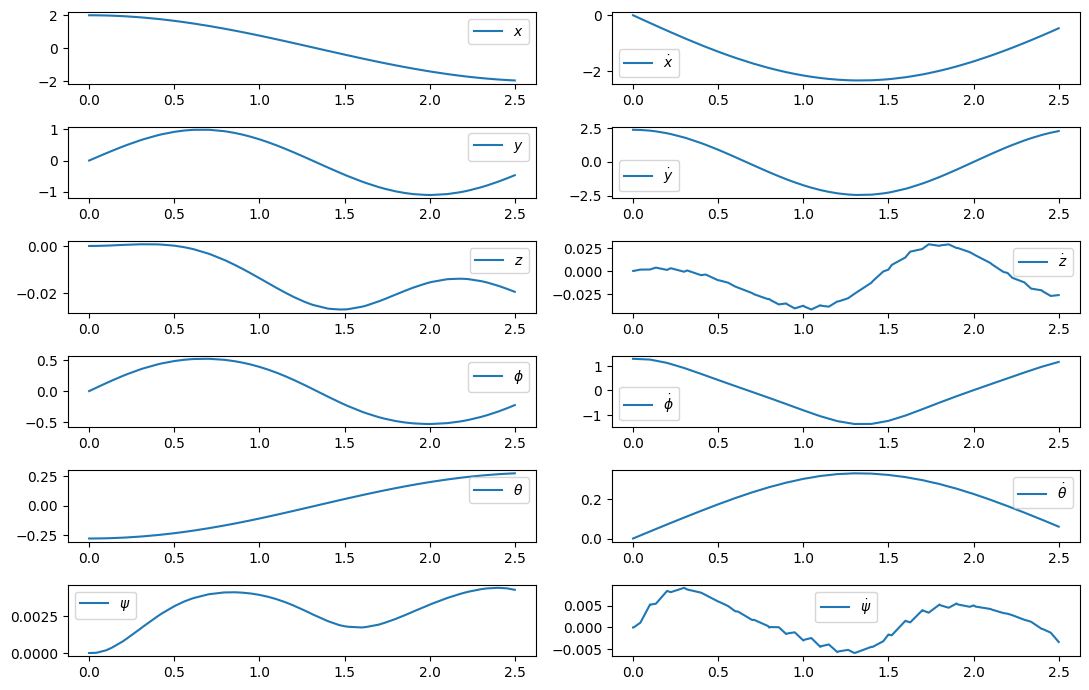

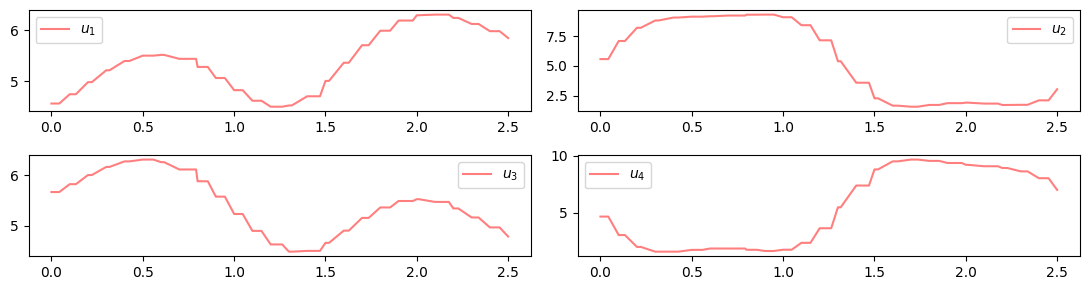

In [10]:
plot_sol(sol)

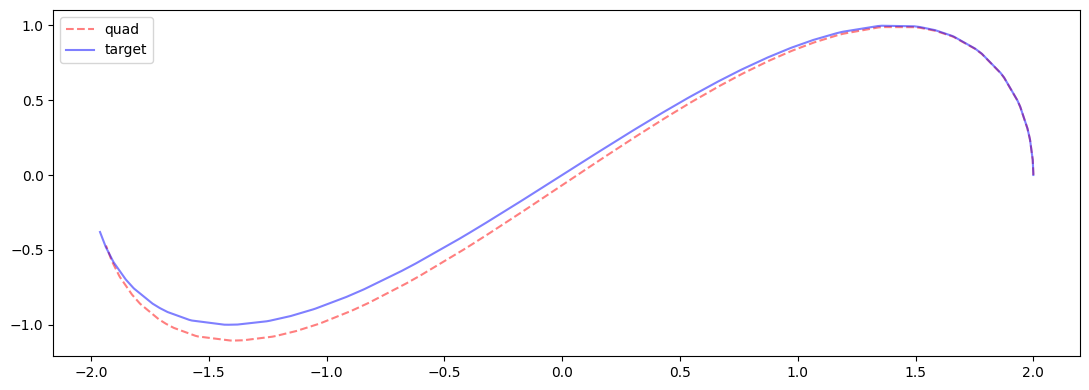

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(
    sol.outputs["state"][:, 0],
    sol.outputs["state"][:, 1],
    "--r",
    alpha=0.5,
    label="quad",
)
ax.plot(
    sol.outputs["x_ref"][:, 0, 0],
    sol.outputs["x_ref"][:, 0, 1],
    "-b",
    alpha=0.5,
    label="target",
)
ax.legend(loc="best")
fig.tight_layout()

In [12]:
animate_quadcopter(sol.outputs["state"][:, :6], sol.outputs["x_ref"][:, 0, :6])

**Note**: This is a demonstration of the nonlinear MPC in Collimator. You may wonder why should we go though this process in this particular case when the reference trajectories obtained by 'differential flatness' analysis were perfect. There are a couple of reasons. First, note that a perfect trajectory is, in general, not available. Second, there may be disturbances in the plant. Finally, even though we used reference trajectories generated by 'differential flatness analysis', the reference trajectory we used for the nonlinear MPC was a discretized version of this (sampled at dt=0.1, so quite crude) and linearly interpolated.

# Direct shooting

In this case for a horizon of N steps, the decision variables are

$$ [u_0, u_1, \cdots, u_{N-1}].$$

Since $x_i$ are not part of the decision variables, they are obtained internally by integrating the dynamics from $x_0$, given a set of decision variables. Thus, there are no equality constraints. The reference trajectories are of the same size as perviously.

Let's look at the signature of `DirectShootingNMPC` to understand the variables we need to create for this block.

In [13]:
print(DirectShootingNMPC.__doc__)


    Implementation of nonlinear MPC with a direct shooting transcription and IPOPT as
    the NLP solver.

    Input ports:
        (0) x_0 : current state vector.
        (1) x_ref : reference state trajectory for the nonlinear MPC.
        (2) u_ref : reference input trajectory for the nonlinear MPC.

    Output ports:
        (1) u_opt : the optimal control input to be applied at the current time step
                    as determined by the nonlinear MPC.

    Parameters:
        plant: LeafSystem or Diagram
            The plant to be controlled.

        Q: Array
            State weighting matrix in the cost function.

        QN: Array
            Terminal state weighting matrix in the cost function.

        R: Array
            Control input weighting matrix in the cost function.

        N: int
            The prediction horizon, an integer specifying the number of steps to
            predict. Note: prediction and control horizons are identical for now.

        nh: int
  

## MPC config

We can now create the variables for the MPC.

In [14]:
x0 = x_ref[
    0
]  # initial state vector for the plant, we can start with the first element of the reference trajectory

N = 10  # Number of time steps per MPC interval
nh = 2  # number of steps to take within an RK4 step for integration of dynamics
dt = 0.1  # timestep in the horizon

Q = 1.0 * jnp.eye(nx)  # Stage penalty matrix for state vector
QN = 3 * Q  # Terminal penalty matrix for state vector
R = 0.01 * jnp.eye(nu)  # Stage penalty matrix for control vector

lb_u = 0.0 * jnp.ones(nu)  # lower bound on control vector
ub_u = 20.0 * jnp.ones(nu)  # upper bound on control vector

u_optvars_0 = jnp.tile(
    u_ref[0], (N, 1)
)  # initial guess for control vector: repeat first element of reference trajectory

if CI:
    N = 2
    nh = 1
    u_optvars_0 = jnp.tile(u_ref[0], (N, 1))

## Simulate MPC

Next, we build the Collimator diagram as usual.

In [15]:
builder = collimator.DiagramBuilder()

quadcopter = builder.add(
    make_quadcopter(config=config, initial_state=x0, name="quadcopter")
)

xref = builder.add(ReferenceTrajectory(t_ref, x_ref, dt, N, name="xref"))
uref = builder.add(ReferenceTrajectory(t_ref, u_ref, dt, N - 1, name="uref"))

mpc = builder.add(
    DirectShootingNMPC(
        make_quadcopter(config=config, initial_state=x0, name="quadcopter"),
        Q,
        QN,
        R,
        N,
        nh,
        dt,
        lb_u=lb_u,
        ub_u=ub_u,
        u_optvars_0=u_optvars_0,
        name="mpc",
    )
)

builder.connect(quadcopter.output_ports[0], mpc.input_ports[0])
builder.connect(xref.output_ports[0], mpc.input_ports[1])
builder.connect(uref.output_ports[0], mpc.input_ports[2])

builder.connect(mpc.output_ports[0], quadcopter.input_ports[0])

diagram = builder.build()
diagram.pprint()

│── root <Diagram>
    │── quadcopter <Diagram> [quadcopter_out_0 → mpc.in_0]
        │── quadcopter <Quadcopter>
    │── xref <ReferenceTrajectory> [out_0 → mpc.in_1]
    │── uref <ReferenceTrajectory> [out_0 → mpc.in_2]
    │── mpc <DirectShootingNMPC> [out_0 → quadcopter.quadcopter_in_0]


We can now simulate, visualize, and automate the solution.

In [16]:
context = diagram.create_context()

recorded_signals = {
    "state": quadcopter.output_ports[0],
    "control": mpc.output_ports[0],
    "x_ref": xref.output_ports[0],
    "u_ref": uref.output_ports[0],
}

tic = time.perf_counter()
sol = collimator.simulate(
    diagram,
    context,
    (0.0, T_sim),
    recorded_signals=recorded_signals,
)
toc = time.perf_counter()
print(f"Direct Shooting NMPC took: {toc-tic}s")

Direct Shooting NMPC took: 40.85669987462461s


(<Figure size 1100x700 with 12 Axes>, <Figure size 1100x300 with 4 Axes>)

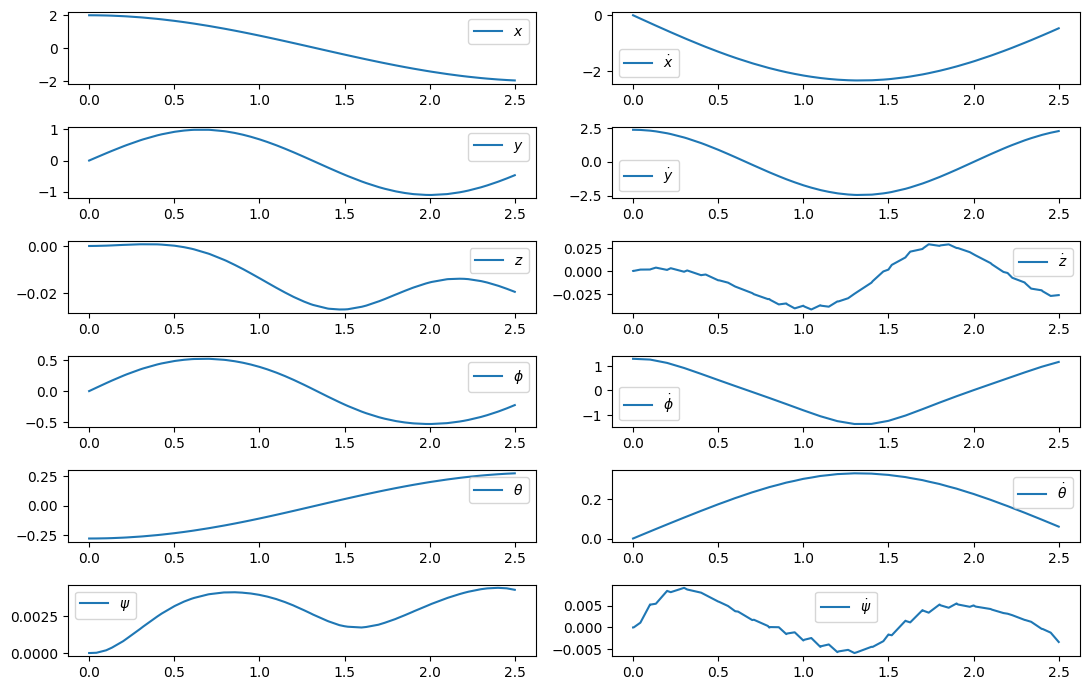

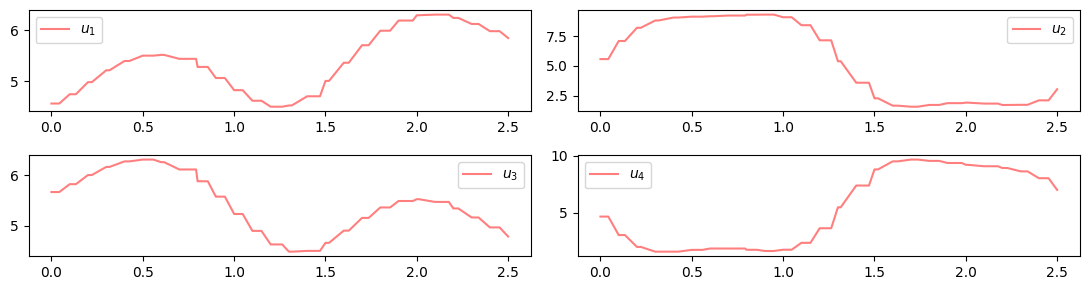

In [17]:
plot_sol(sol)

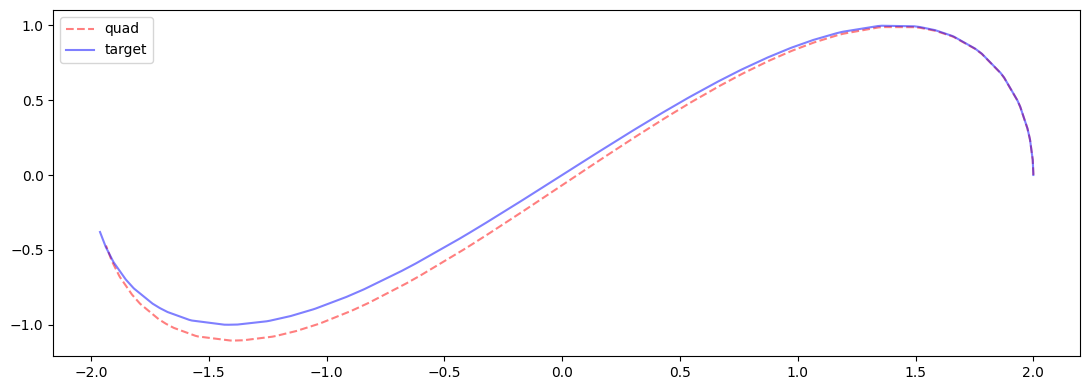

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(
    sol.outputs["state"][:, 0],
    sol.outputs["state"][:, 1],
    "--r",
    alpha=0.5,
    label="quad",
)
ax.plot(
    sol.outputs["x_ref"][:, 0, 0],
    sol.outputs["x_ref"][:, 0, 1],
    "-b",
    alpha=0.5,
    label="target",
)
ax.legend(loc="best")
fig.tight_layout()

In [19]:
animate_quadcopter(sol.outputs["state"][:, :6], sol.outputs["x_ref"][:, 0, :6])

# Direct collocation MPC (Hermite-Simpson)

In this case for a horizon of N steps, the decision variables are

$$ [x_0, x_1, \cdots, x_N,\quad u_0, u_1, \cdots, u_{N}].$$

Note that $u_N$ is now part of the decision variables. Since $x_i$ form part of the decision variables, the dynamics appear as constraints, although these are evaluated by taking advantage of the polynomial properties and thus differently to Direct Transcription method above. Furthermore, explicit RK4 integration is not necessary. See [1] for more details. The reference trajectories for $x$ and $u$ are both of size $([N+1] \times n_x)$. These are also the sizes of the initial guesses for the optimization problem.

Let's look at the signature of `HermiteSimpsonNMPC` to understand the variables we need to create for this block.


In [20]:
print(HermiteSimpsonNMPC.__doc__)


    Implementation of nonlinear MPC with Hermite-Simpson collocation and IPOPT as the
    NLP solver.

    Input ports:
        (0) x_0 : current state vector.
        (1) x_ref : reference state trajectory for the nonlinear MPC.
        (2) u_ref : reference input trajectory for the nonlinear MPC.

    Output ports:
        (1) u_opt : the optimal control input to be applied at the current time step
                    as determined by the nonlinear MPC.

    Parameters:
        plant: LeafSystem or Diagram
            The plant to be controlled.

        Q: Array
            State weighting matrix in the cost function.

        QN: Array
            Terminal state weighting matrix in the cost function.

        R: Array
            Control input weighting matrix in the cost function.

        N: int
            The prediction horizon, an integer specifying the number of steps to
            predict. Note: prediction and control horizons are identical for now.

        dt: float:
   

In addition to the usual parameters, we also have options to include the terminal state and terminal control vector in each horizon as a constraint. This parameter should be `False` for receding horizon cases, as we are demonstrating now, but quite useful for optimization over a fixed horizon, where we may want to impose the terminal state as a constraint (see, for example, the notebook on `trajectory optimization and stabilization`. Also note that we do not need the `nh` parameter for the number of steps within RK4 integration as explicit integration of dynamics is not necessary in Hermite-Simpson collocation.

## MPC config

We can now create the variables for the MPC.

In [21]:
x0 = x_ref[
    0
]  # initial state vector for the plant, we can start with the first element of the reference trajectory

N = 10  # Number of time steps per MPC interval
nh = 2  # number of steps to take within an RK4 step for integration of dynamics
dt = 0.1  # timestep in the horizon

Q = 1.0 * jnp.eye(nx)  # Stage penalty matrix for state vector
QN = 3 * Q  # Terminal penalty matrix for state vector
R = 0.01 * jnp.eye(nu)  # Stage penalty matrix for control vector

lb_x = None  # no bound on state vector
ub_x = None  # no bound on state vector

lb_u = 0.0 * jnp.ones(nu)  # lower bound on control vector
ub_u = 20.0 * jnp.ones(nu)  # upper bound on control vector

x_optvars_0 = jnp.tile(x0, (N + 1, 1))  # initial guess for control vector: repear x0
u_optvars_0 = jnp.tile(
    u_ref[0], (N + 1, 1)
)  # initial guess for control vector: repeat first element of reference trajectory

## Simulate MPC

Next, we build the Collimator diagram as usual.

In [22]:
builder = collimator.DiagramBuilder()

quadcopter = builder.add(
    make_quadcopter(config=config, initial_state=x0, name="quadcopter")
)

xref = builder.add(ReferenceTrajectory(t_ref, x_ref, dt, N, name="xref"))
uref = builder.add(ReferenceTrajectory(t_ref, u_ref, dt, N, name="uref"))

mpc = builder.add(
    HermiteSimpsonNMPC(
        make_quadcopter(config=config, initial_state=x0, name="quadcopter"),
        Q,
        QN,
        R,
        N,
        dt,
        lb_x=lb_x,
        ub_x=ub_x,
        lb_u=lb_u,
        ub_u=ub_u,
        include_terminal_x_as_constraint=False,
        include_terminal_u_as_constraint=False,
        x_optvars_0=x_optvars_0,
        u_optvars_0=u_optvars_0,
        name="mpc",
    )
)

builder.connect(quadcopter.output_ports[0], mpc.input_ports[0])
builder.connect(xref.output_ports[0], mpc.input_ports[1])
builder.connect(uref.output_ports[0], mpc.input_ports[2])

builder.connect(mpc.output_ports[0], quadcopter.input_ports[0])

diagram = builder.build()
diagram.pprint()

│── root <Diagram>
    │── quadcopter <Diagram> [quadcopter_out_0 → mpc.in_0]
        │── quadcopter <Quadcopter>
    │── xref <ReferenceTrajectory> [out_0 → mpc.in_1]
    │── uref <ReferenceTrajectory> [out_0 → mpc.in_2]
    │── mpc <HermiteSimpsonNMPC> [out_0 → quadcopter.quadcopter_in_0]


We can now simulate, visualize, and automate the solution.

In [23]:
context = diagram.create_context()

recorded_signals = {
    "state": quadcopter.output_ports[0],
    "control": mpc.output_ports[0],
    "x_ref": xref.output_ports[0],
    "u_ref": uref.output_ports[0],
}

tic = time.perf_counter()
sol = collimator.simulate(
    diagram,
    context,
    (0.0, T_sim),
    recorded_signals=recorded_signals,
)
toc = time.perf_counter()
print(f"Direct Shooting NMPC took: {toc-tic}s")

Direct Shooting NMPC took: 99.17061162507161s


(<Figure size 1100x700 with 12 Axes>, <Figure size 1100x300 with 4 Axes>)

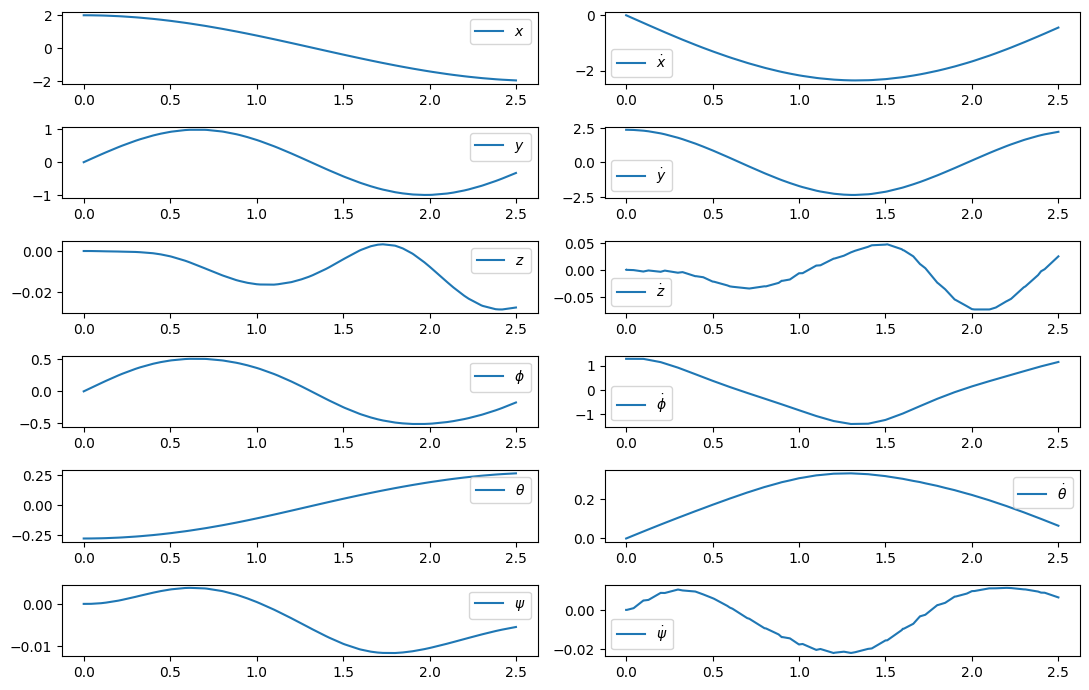

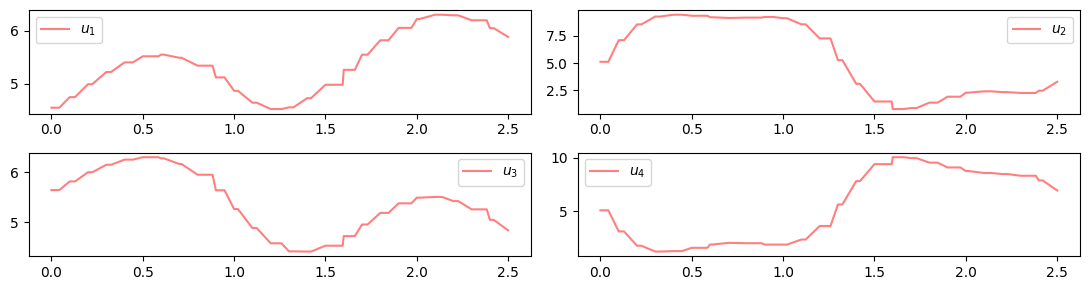

In [24]:
plot_sol(sol)

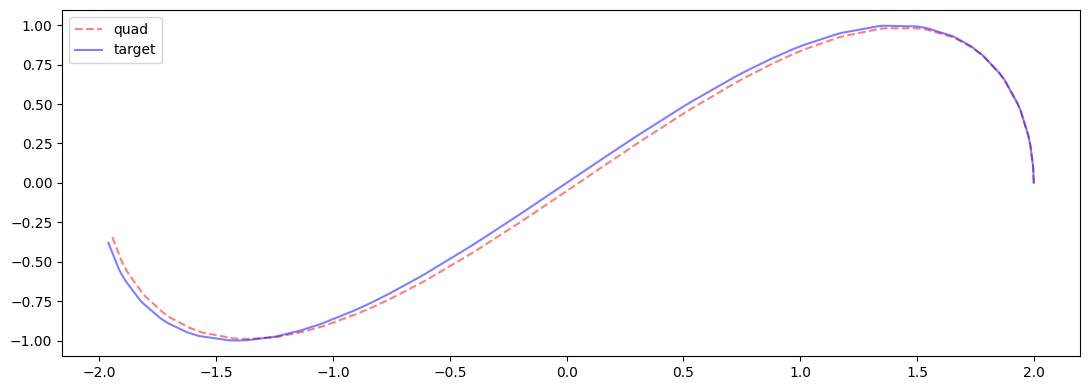

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(11, 4))
ax.plot(
    sol.outputs["state"][:, 0],
    sol.outputs["state"][:, 1],
    "--r",
    alpha=0.5,
    label="quad",
)
ax.plot(
    sol.outputs["x_ref"][:, 0, 0],
    sol.outputs["x_ref"][:, 0, 1],
    "-b",
    alpha=0.5,
    label="target",
)
ax.legend(loc="best")
fig.tight_layout()

In [26]:
animate_quadcopter(sol.outputs["state"][:, :6], sol.outputs["x_ref"][:, 0, :6])

Finally, note that MPCs typically require tuning with respect to the optimization parameters (for example, the horizon length, number of steps within the horizon, penalty matrices, etc.) to achieve good performance.